In [1]:
import torch
import functools
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [2]:
import sys
sys.path.append('..')
from src.scripts import train, models, analysis

In [3]:
def get_best_device(fallback="cpu"):
    return torch.device("cuda:0" if torch.cuda.is_available() else fallback)

In [4]:
DEVICE = get_best_device()

In [5]:
DER_TYPE = 'DER'  # 'sDER'

In [6]:
BATCH_SIZE = 100
N_SAMPLES = 50
N_EPOCHS = 500

if DER_TYPE == 'DER':
    LR = 5e-4    # learning rate
    COEFF = .01  # lambda
else:
    LR = .005    # learning rate
    COEFF = 2.   # lambda

In [7]:
if DER_TYPE == 'DER':
    DERLayer = models.DERLayer
    loss_der = models.loss_der
else:
    DERLayer = models.SDERLayer
    loss_der = models.loss_sder

## Generate data
This is the same as in the DeepEnsemble

In [8]:
# same simulator as in likelihood-based inference,
# but here we have 
def simulator(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    sigma = 10
    ε = rs.normal(loc=0, scale=sigma, size = len(x_data)) 
    return m * x_data + b + ε

def simulator_no_noise(thetas):
    m, b = thetas
    x_data = np.linspace(0, 100, 101)
    rs = np.random.RandomState()#2147483648)# 
    return m * x_data + b

In [9]:
x_data = np.linspace(0, 100, 101)

length_df = 1000
#ms = np.zeros((length_df, 101))
ms_list = []#np.zeros((length_df, 1))
bs_list = []#np.zeros((length_df, 1))
ys_list = []
#true_sigmas = []

for r in range(length_df):
    rs = np.random.RandomState()#2147483648)# 
    m = rs.uniform(low=0, high=10)
    b = rs.uniform(low=-10, high=10)    
    ms_list.append(m)
    bs_list.append(b)
    '''
    xs[r,:] = thetas_1d[0]#np.linspace(0, 100, 101)
    ms[r,:] = thetas_1d[1]#np.repeat(thetas_1d[0], 101)
    bs[r,:] = thetas_1d[2]#np.repeat(thetas_1d[1], 101)
    sigmas[r,:] = thetas_1d[3]#np.repeat(thetas_1d[2], 101)
    '''
    ys_list.append(simulator([m,b]))
ms_array = np.repeat(ms_list, len(x_data))
bs_array = np.repeat(bs_list, len(x_data))
xs_array = np.tile(x_data, length_df)
ys_array = np.reshape(ys_list, (length_df * len(x_data)))

<Figure size 640x480 with 0 Axes>

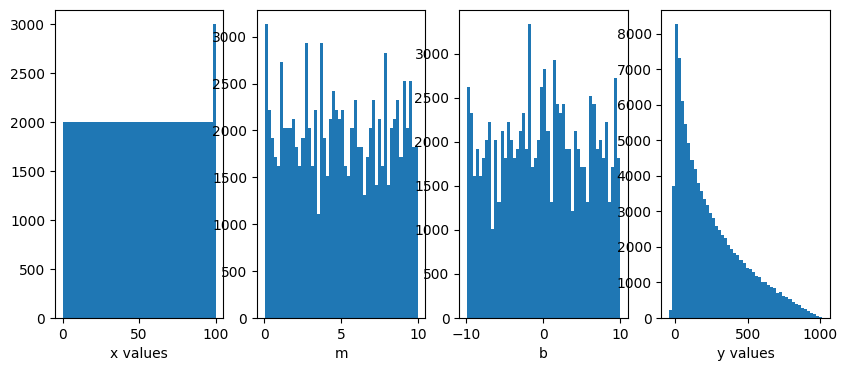

In [10]:
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(xs_array, bins=50)
ax0.set_xlabel('x values')
ax1 = fig.add_subplot(142)
ax1.hist(ms_array, bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(bs_array, bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(ys_array, bins=50)
ax3.set_xlabel('y values')
plt.show()

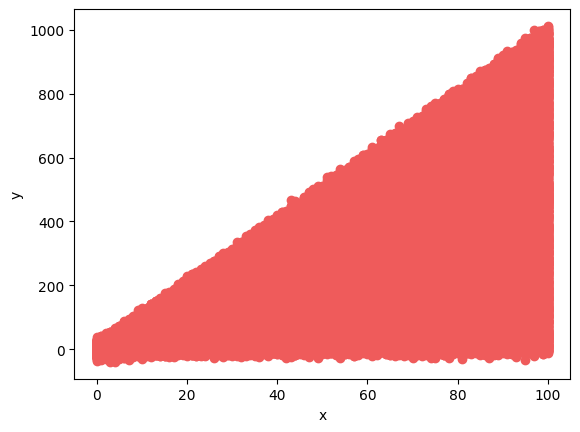

In [11]:
# visualize it before we normalize it
plt.scatter(xs_array, ys_array, color = '#EF5B5B')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [12]:
# combine all of the inputs into one array
# this will be fed into the neural network
inputs = np.array([xs_array, ms_array, bs_array]).T
print(np.shape(inputs))

(101000, 3)


In [13]:
# normalize everything before it goes into a network
inputmin = np.min(inputs, axis = 0)
inputmax = np.max(inputs, axis = 0)#, axis = 0)
outputmin = np.min(ys_array)
outputmax = np.max(ys_array)
print('input min, max', inputmin, inputmax, 'output min, max', outputmin, outputmax)

norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys_array - outputmin) / (outputmax - outputmin)

input min, max [ 0.          0.01254674 -9.9419251 ] [100.           9.99440054   9.99485477] output min, max -40.020524712525464 1012.7633967547177


<Figure size 640x480 with 0 Axes>

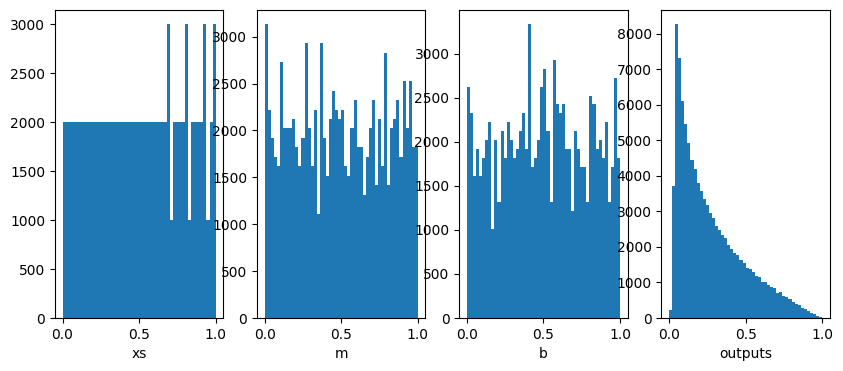

In [14]:
# now plot the histograms of the noramlized values
# to verify it worked
plt.clf()
fig = plt.figure(figsize = (10,4))
ax0 = fig.add_subplot(141)
ax0.hist(norm_inputs[:,0], bins=50)
ax0.set_xlabel('xs')
ax1 = fig.add_subplot(142)
ax1.hist(norm_inputs[:,1], bins=50)
ax1.set_xlabel('m')
ax2 = fig.add_subplot(143)
ax2.hist(norm_inputs[:,2], bins=50)
ax2.set_xlabel('b')
ax3 = fig.add_subplot(144)
ax3.hist(norm_outputs[:], bins=50)
ax3.set_xlabel('outputs')
plt.show()

(90900, 3) (90900,)
(3,)


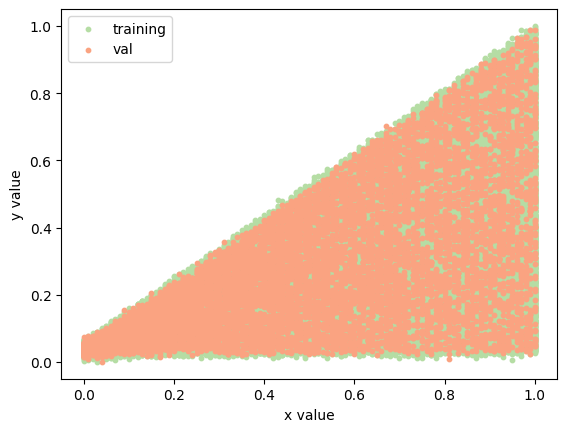

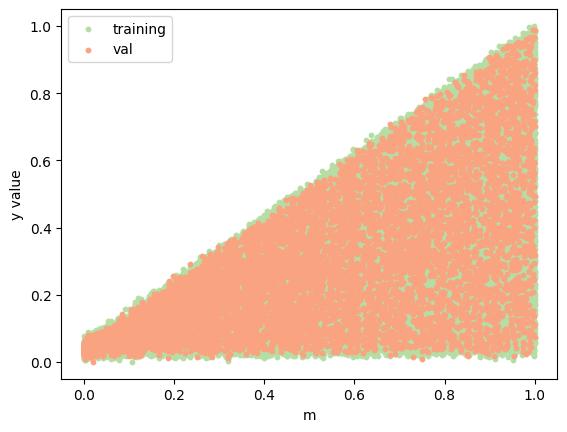

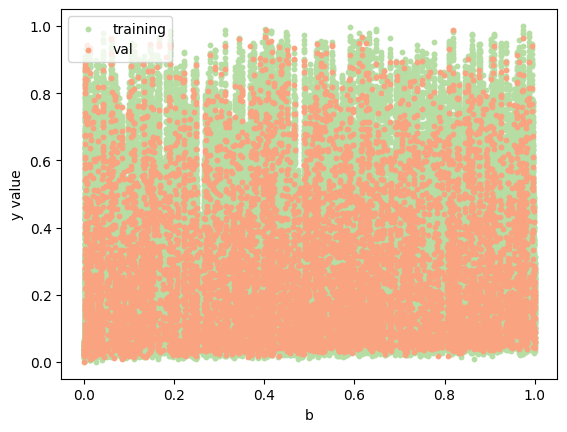

In [15]:
# prepare the training, validation, and test set split:
val_proportion = 0.1
x_train, x_val, y_train, y_val = train_test_split(norm_inputs, norm_outputs, test_size=val_proportion, random_state=42)

print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_train[:][0]))


plt.clf()
plt.scatter(x_train[:,0], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,0], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('x value')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,1], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,1], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('m')
plt.ylabel('y value')
plt.show()

plt.clf()
plt.scatter(x_train[:,2], y_train, label = 'training', color = '#B5DDA4', s = 10)
plt.scatter(x_val[:,2], y_val, label = 'val', color = '#FAA381', s = 10)
plt.legend()
plt.xlabel('b')
plt.ylabel('y value')
plt.show()

In [16]:
# okay now train the thing
BATCH_SIZE = 128

# add a dimension so that xs have a one channel input
#x_train = x_train.reshape(x_train.shape[0], 1) # 1 was the middle dimension
#x_val = x_val.reshape(x_val.shape[0], 1)

'''
print('y', np.shape(y_train))
print('x', np.shape(x_train))
STOP
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]) # 1 was the middle dimension
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1])
#x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1], x_test.shape[1])
'''

trainData = TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train))
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)

valData = TensorDataset(torch.Tensor(x_val), torch.Tensor(y_val))
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE

print('shape of training set', np.shape(x_train))

shape of training set (90900, 3)


[INFO] training the network...
saving checkpoints?
False
starting here 0
epoch 0 0.0


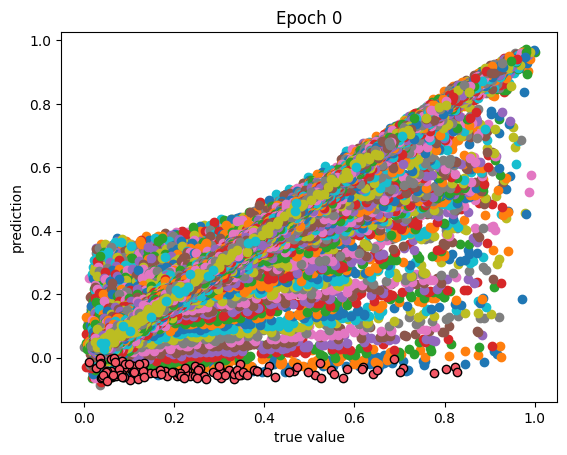

new best loss -2.8435609340667725 in epoch 0
epoch 1 0.01
epoch 2 0.02
new best loss -2.9785945415496826 in epoch 2
epoch 3 0.03
new best loss -3.015299081802368 in epoch 3
epoch 4 0.04
new best loss -3.1703052520751953 in epoch 4
epoch 5 0.05


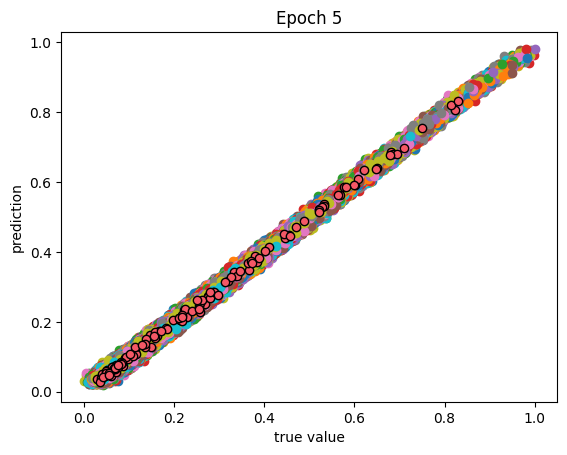

epoch 6 0.06
new best loss -3.181633949279785 in epoch 6
epoch 7 0.07
epoch 8 0.08
epoch 9 0.09
epoch 10 0.1


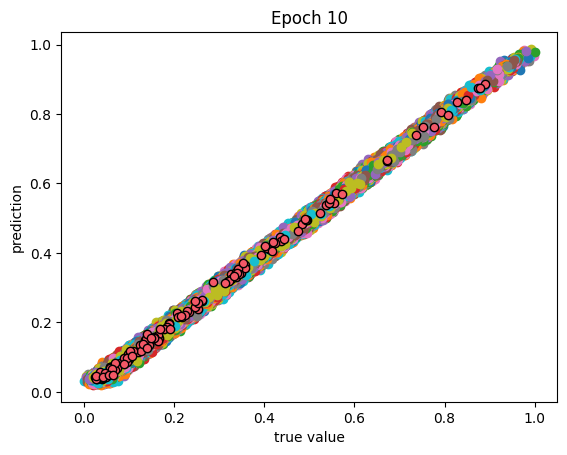

epoch 11 0.11
new best loss -3.1870548725128174 in epoch 11
epoch 12 0.12
new best loss -3.2034521102905273 in epoch 12
epoch 13 0.13
epoch 14 0.14
new best loss -3.206650733947754 in epoch 14
epoch 15 0.15


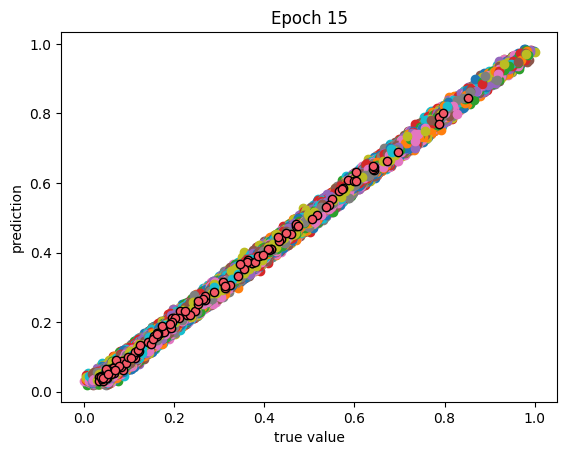

epoch 16 0.16
epoch 17 0.17
epoch 18 0.18
epoch 19 0.19
epoch 20 0.2


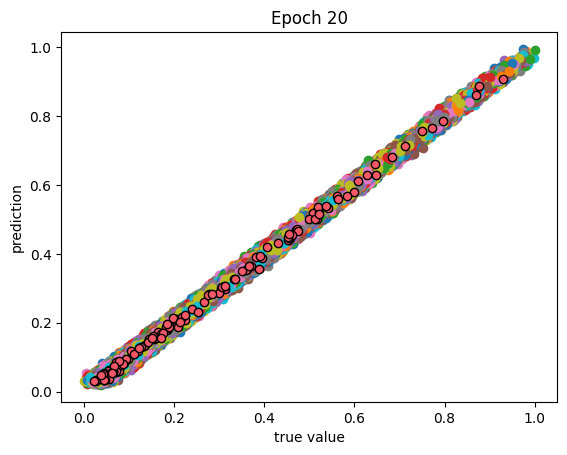

epoch 21 0.21
epoch 22 0.22
epoch 23 0.23
epoch 24 0.24
epoch 25 0.25


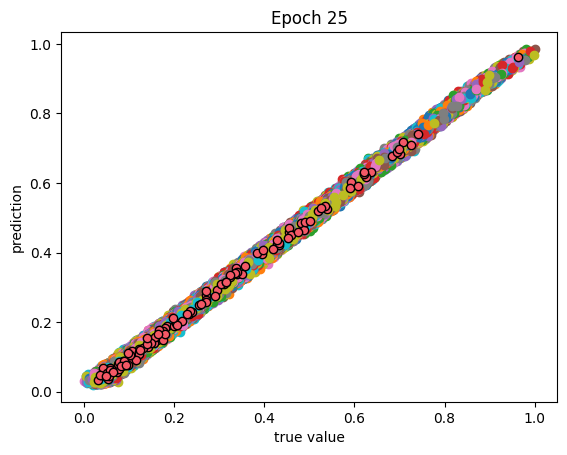

epoch 26 0.26
epoch 27 0.27
new best loss -3.2130820751190186 in epoch 27
epoch 28 0.28
epoch 29 0.29
epoch 30 0.3


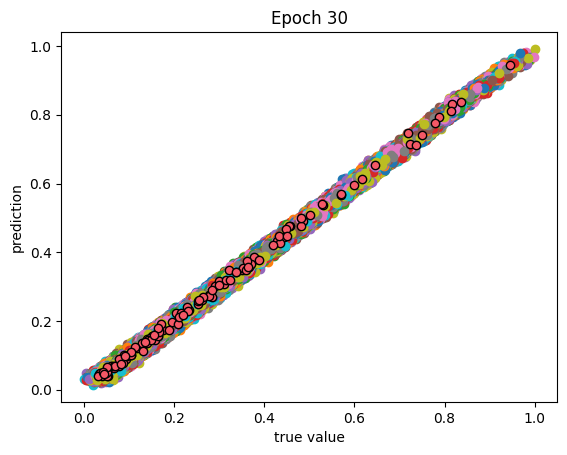

epoch 31 0.31
new best loss -3.2140233516693115 in epoch 31
epoch 32 0.32
epoch 33 0.33
epoch 34 0.34
epoch 35 0.35


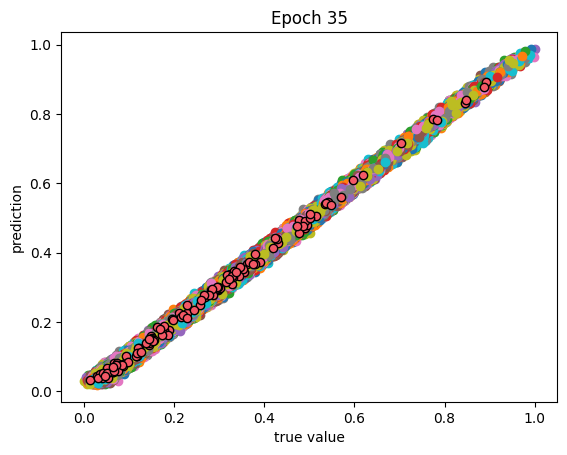

epoch 36 0.36
epoch 37 0.37
epoch 38 0.38
new best loss -3.2212119102478027 in epoch 38
epoch 39 0.39
epoch 40 0.4


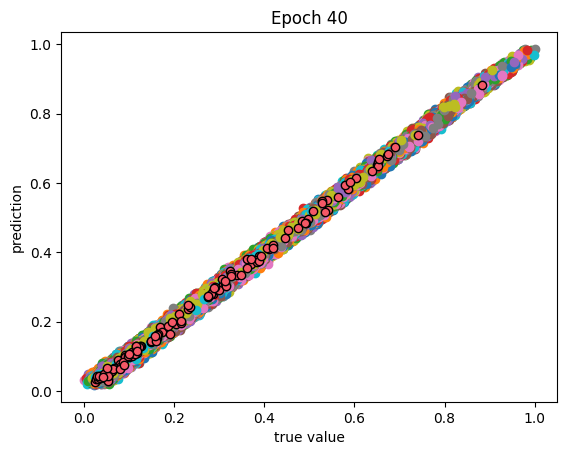

epoch 41 0.41
epoch 42 0.42
epoch 43 0.43
epoch 44 0.44
epoch 45 0.45


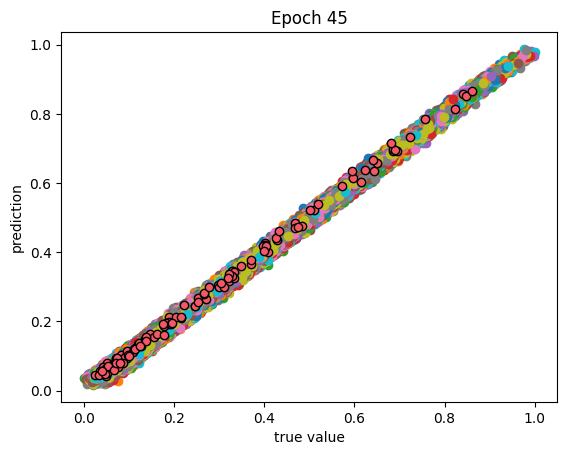

epoch 46 0.46
epoch 47 0.47
epoch 48 0.48
epoch 49 0.49
epoch 50 0.5


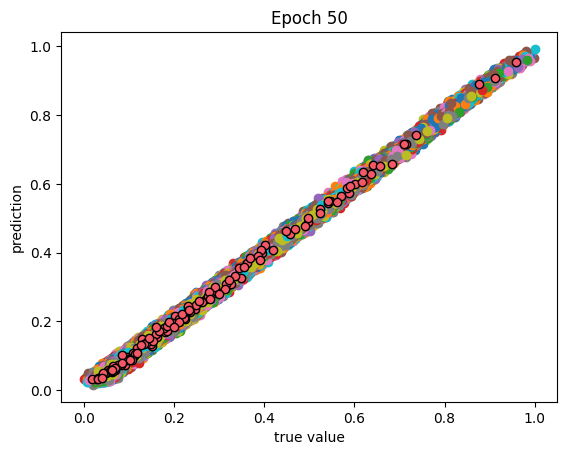

epoch 51 0.51
epoch 52 0.52
epoch 53 0.53
epoch 54 0.54
epoch 55 0.55


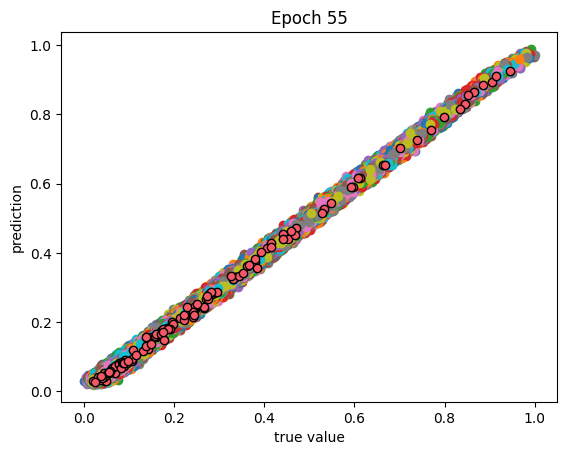

epoch 56 0.56
epoch 57 0.57
epoch 58 0.58
epoch 59 0.59
epoch 60 0.6


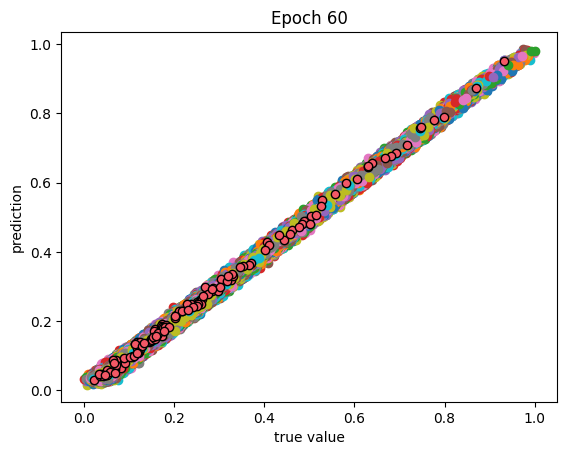

epoch 61 0.61
epoch 62 0.62
epoch 63 0.63
epoch 64 0.64
epoch 65 0.65


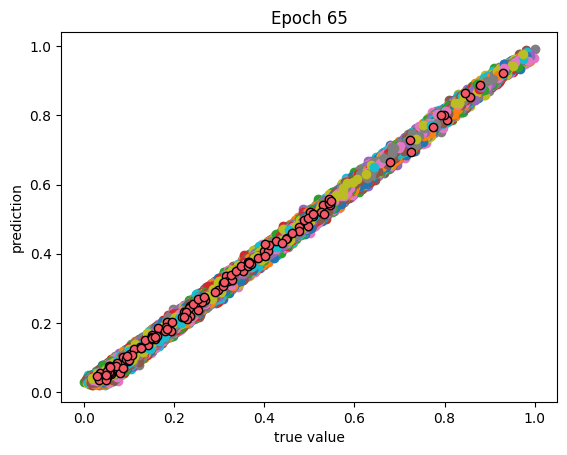

epoch 66 0.66
epoch 67 0.67
new best loss -3.222543954849243 in epoch 67
epoch 68 0.68
epoch 69 0.69
epoch 70 0.7


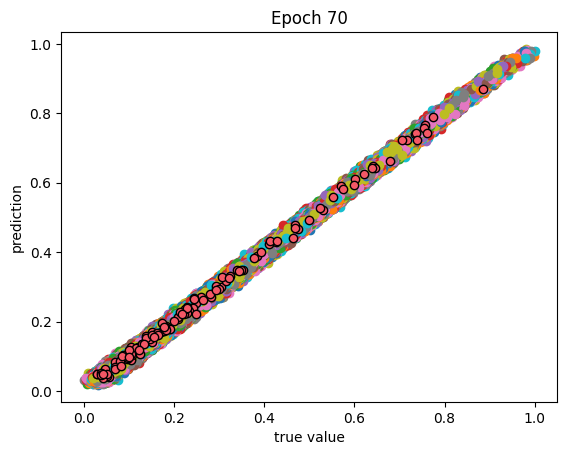

epoch 71 0.71
epoch 72 0.72
epoch 73 0.73
epoch 74 0.74
epoch 75 0.75


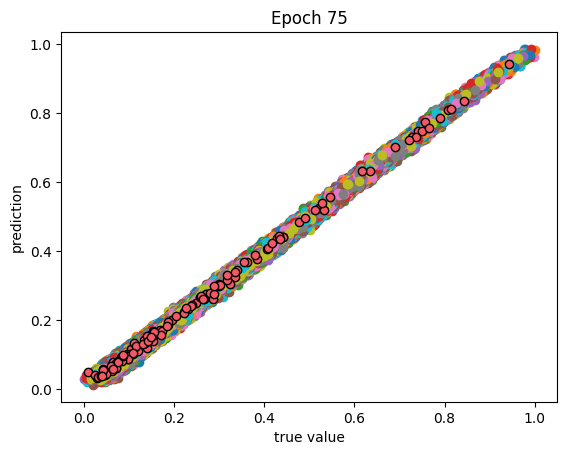

epoch 76 0.76
epoch 77 0.77
epoch 78 0.78
epoch 79 0.79
epoch 80 0.8


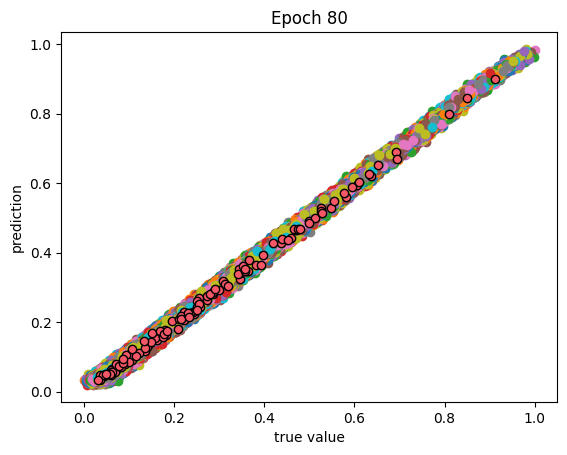

epoch 81 0.81
epoch 82 0.82
epoch 83 0.83
epoch 84 0.84
epoch 85 0.85


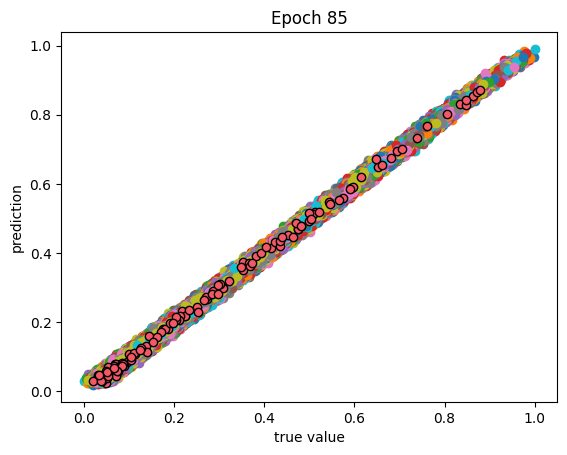

epoch 86 0.86
epoch 87 0.87
epoch 88 0.88
epoch 89 0.89
epoch 90 0.9


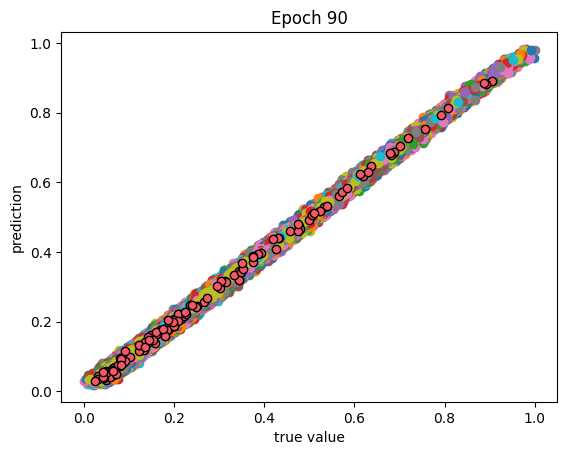

epoch 91 0.91
epoch 92 0.92
epoch 93 0.93
epoch 94 0.94
epoch 95 0.95


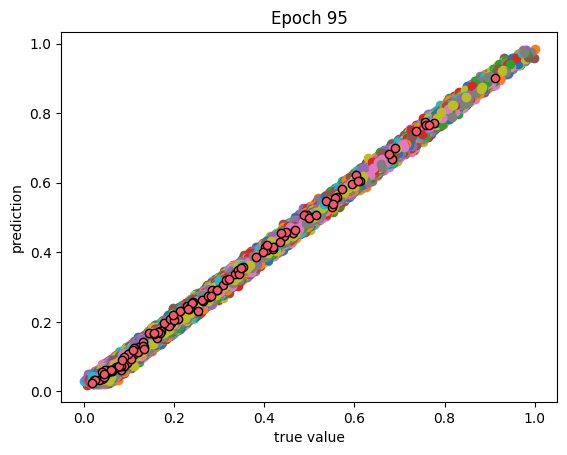

epoch 96 0.96
epoch 97 0.97
epoch 98 0.98
epoch 99 0.99
start at 1704234508.836063 end at 1704234606.138645
97.30258202552795


<Figure size 640x480 with 0 Axes>

In [17]:
# my own training model
DER_type = 'DER'
INIT_LR = LR
model_ensemble = train.train_DER(trainDataLoader,
             x_val,
             y_val,
             INIT_LR,
             DEVICE,
             COEFF,
             DER_type,
             model_name='DER',
             EPOCHS=100,
             save_checkpoints=False,
             plot=True)
 

### Compute the uncertainty
The original aleatoric and epistemic uncertainty (from OG paper):
$u_{al} = \sqrt{\frac{\beta_i}{(\alpha_i-1)}}$; $u_{ep} = \sqrt{\frac{\beta_i}{v_i(\alpha_i-1)}}$

The revised aleatoric and epistemic uncertainty:
$u_{al} = \sqrt{\frac{\beta_i (1+v_i)}{\alpha_i v_i}}$; $u_{ep} = \frac{1}{\sqrt{v_i}}$

The order of the parameters for a normal-inverse-gamma distribution is:
$$m = (\gamma, \nu, \alpha, \beta)$$

### Plot the aleatoric errors by data point

In [34]:
m_true = np.repeat(1, len(x_data))
b_true = np.repeat(5, len(x_data))


thetas_1d_true = np.array([x_data, m_true, b_true]).T
y_true = simulator([m_true[0], b_true[0]])
y_true_no_noise = simulator_no_noise([m_true[0], b_true[0]])
# now use the NN to make a prediction
model = model_ensemble
model.eval()
# first, normalize the x value using the xmin and xmax before
'''
norm_inputs = (inputs - inputmin) / (inputmax - inputmin)
norm_outputs = (ys - outputmin) / (outputmax - outputmin)
'''
norm_thetas = (thetas_1d_true - inputmin) / (inputmax - inputmin)

y_norm_pred = model(torch.Tensor(norm_thetas)).detach().numpy()
# now un-normalize this so you can plot it
y_pred = (y_norm_pred[:,0]) * (outputmax - outputmin) + outputmin
aleatoric_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,2] - 1))
aleatoric_mod = np.sqrt((y_norm_pred[:,3] * (1 + y_norm_pred[:,1])) / (y_norm_pred[:,2] * y_norm_pred[:,1]))

In [35]:
print(aleatoric_OG)
print(aleatoric_mod)

[0.00811753 0.0081118  0.00810609 0.00810025 0.00809442 0.00808859
 0.00808277 0.00807814 0.00807669 0.00808731 0.00809795 0.00810112
 0.00810318 0.00810347 0.00809618 0.00808891 0.00808164 0.00807439
 0.00806714 0.0080599  0.00805268 0.00804546 0.00803825 0.00803105
 0.00802416 0.0080197  0.00801525 0.00801081 0.00800637 0.00800194
 0.00799681 0.00799119 0.00798558 0.00797998 0.00797438 0.00796879
 0.00796322 0.00795765 0.00795283 0.0079517  0.00795939 0.00796708
 0.00797479 0.00798251 0.00799023 0.00800044 0.00801237 0.00802459
 0.00803751 0.00805045 0.00806117 0.00806734 0.00807186 0.00807639
 0.00808093 0.00808547 0.00809002 0.00809411 0.00809643 0.00809877
 0.00810111 0.00810346 0.00810458 0.00810477 0.00810538 0.0081061
 0.00810684 0.00810816 0.00811014 0.00811212 0.00811412 0.0081161
 0.00811811 0.00812011 0.00812212 0.00812261 0.00810939 0.00809621
 0.00808305 0.00807123 0.00807558 0.00808486 0.00810191 0.00811901
 0.00813677 0.00815288 0.00816721 0.00818156 0.00819595 0.008210

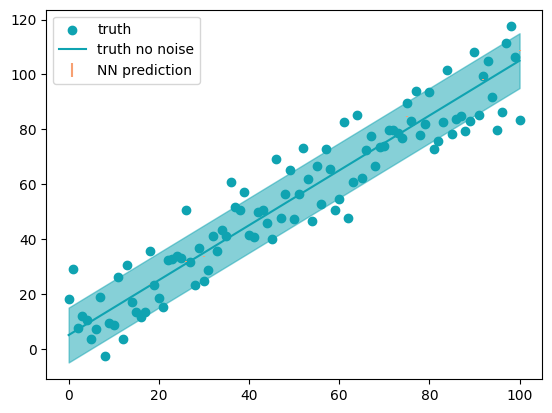

In [37]:
# plot
plt.clf()
plt.scatter(x_data, y_true, label = 'truth', color = '#0FA3B1')
plt.fill_between(x_data, y_true_no_noise - 10,
                 y_true_no_noise + 10, color = '#0FA3B1', alpha = 0.5)
#plt.scatter(x_data, y_pred, label = 'NN prediction', color = '#F7A072')
plt.errorbar(x_data, y_pred, yerr = aleatoric_OG,
             label = 'NN prediction', color = '#F7A072',
             ls = 'None')
plt.plot(x_data, y_true_no_noise, label = 'truth no noise', color = '#0FA3B1')
plt.legend()
plt.show()


### Now epistemic

In [38]:
epistemic_OG = np.sqrt(y_norm_pred[:,3] / (y_norm_pred[:,1]*(y_norm_pred[:,2] - 1)))
epistemic_mod = 1 / np.sqrt(y_norm_pred[:,1])

In [40]:
print, epistemic_OG, epistemic_mod 

(<function print>,
 array([0.00573718, 0.00573467, 0.00573217, 0.00572929, 0.00572641,
        0.00572354, 0.00572067, 0.00571871, 0.00571918, 0.00572886,
        0.00573856, 0.00574231, 0.00574517, 0.0057467 , 0.00574255,
        0.0057384 , 0.00573426, 0.00573013, 0.005726  , 0.00572187,
        0.00571775, 0.00571364, 0.00570953, 0.00570542, 0.00570166,
        0.00570071, 0.00569977, 0.00569884, 0.0056979 , 0.00569698,
        0.00569544, 0.00569347, 0.00569151, 0.00568955, 0.00568759,
        0.00568564, 0.00568369, 0.00568175, 0.0056805 , 0.00568249,
        0.00569178, 0.00570111, 0.00571045, 0.00571981, 0.00572919,
        0.00574044, 0.00575297, 0.00576573, 0.00577901, 0.00579232,
        0.00580387, 0.00581033, 0.005813  , 0.00581568, 0.00581837,
        0.00582105, 0.00582374, 0.00582607, 0.00582702, 0.00582799,
        0.00582895, 0.00582992, 0.00582984, 0.00582896, 0.00582841,
        0.00582795, 0.00582751, 0.00582759, 0.00582827, 0.00582895,
        0.00582964, 0.0058303